# Causal Influence Decomposition of the Human Brain Using Multi-site In-silico Perturbation Analysis


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from msapy import msa, plottings as pl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import networkx as nx
import seaborn as sns
import utils as ut
import pandas as pd
from netneurotools.metrics import communicability_wei, communicability_bin, distance_wei_floyd
from scipy.stats import pearsonr
import warnings
from sklearn.preprocessing import StandardScaler
import scipy

In [3]:
import session_info
session_info.show()

In [4]:

SEED = 2023
pl.set_style(font_size=8)
CM = 1/2.54

DEEP_BLUE = '#006685'
BLUE = '#3FA5C4'
WHITE = '#FFFFFF'
HALF_BLACK = '#232324'
ORANGE = '#E84653'
RED = '#BF003F'

PURPLE = '#A6587C'
PURPLER = '#591154'
PURPLEST = '#260126'
NIGHT_BLUE = '#394D73'
YELLOW = '#E6B213'


from_white = [DEEP_BLUE, BLUE, WHITE, ORANGE, RED]
white_to_reds = [WHITE, ORANGE, RED]
white_to_blues = [WHITE, BLUE, DEEP_BLUE]

black_to_reds = [HALF_BLACK, ORANGE, RED]
black_to_blues = [HALF_BLACK, BLUE, DEEP_BLUE]

from_black = [DEEP_BLUE,BLUE,HALF_BLACK,ORANGE,RED]
purples = [PURPLE, WHITE, NIGHT_BLUE]


diverge_from_white = sns.blend_palette(from_white,as_cmap=True)
purples_diverge_from_white = sns.blend_palette(purples,as_cmap=True)

diverge_from_black = sns.blend_palette(from_black,as_cmap=True)

white_red_mono = sns.blend_palette(white_to_reds,as_cmap=True)
white_blue_mono = sns.blend_palette(white_to_blues,as_cmap=True)

black_red_mono = sns.blend_palette(black_to_reds,as_cmap=True)
black_blue_mono = sns.blend_palette(black_to_blues,as_cmap=True)

purple_red = sns.blend_palette([PURPLEST, PURPLE, RED])

sagittal=(0, 180)
axial=(90, 180)
coronal=(0, 90)
bottom=(-90,0)

scatter_kw = dict(alpha=1,linewidths=0.7,edgecolors='k')
size=80

In [5]:
rng = np.random.default_rng(seed=SEED)
chain = nx.to_numpy_array(nx.generators.path_graph(6,nx.DiGraph())).T


closedchain = chain.copy()
closedchain[0,5]=1
closedchain = ut.spectral_normalization(0.9,closedchain)

chain *= 0.9

symmetricchain = nx.to_numpy_array(nx.generators.path_graph(6))
symmetricchain = ut.spectral_normalization(0.9,symmetricchain)

timesteps = 100
example_input = ut.event_maker(6,timesteps)


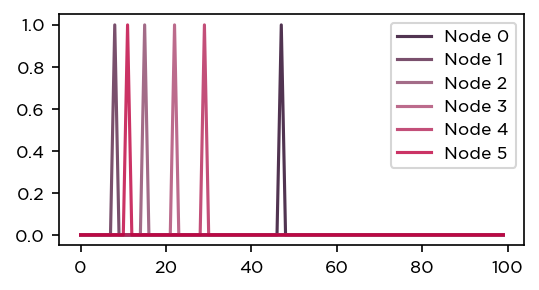

In [6]:
plt.figure(figsize=(4,2),dpi=150)
with sns.color_palette(purple_red,n_colors=example_input.shape[0]):
    plt.plot(example_input.T,alpha=0.8)
plt.legend(['Node 0','Node 1','Node 2','Node 3','Node 4','Node 5']);

In [7]:
NOISE_STRENGTH = 0.05
DELTA = 0.01
TAU = 0.02
G =0.74
DURATION = 1
model_params = {'dt':DELTA,'timeconstant':TAU,'coupling':G,'duration':DURATION}

In [8]:
warnings.filterwarnings("ignore")

simple_chain_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=chain,
                                                              input_matrix=example_input,
                                                                 **model_params)
closed_chain_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=closedchain,
                                                              input_matrix=example_input,
                                                                 **model_params)
symmetric_chain_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=symmetricchain,
                                                                 input_matrix=example_input,
                                                                 **model_params)

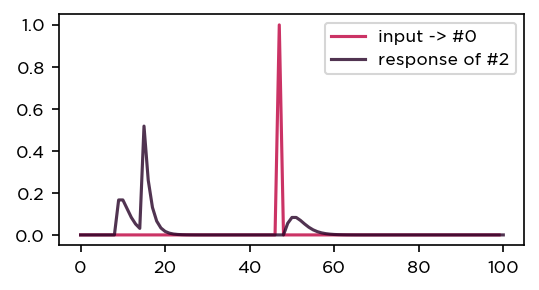

In [9]:
plt.figure(figsize=(4,2),dpi=150)

plt.plot(example_input[0],alpha=0.8,color=RED)
plt.plot(simple_chain_dynamics[2],alpha=0.8,color=PURPLEST)

plt.legend(['input -> #0','response of #2']);


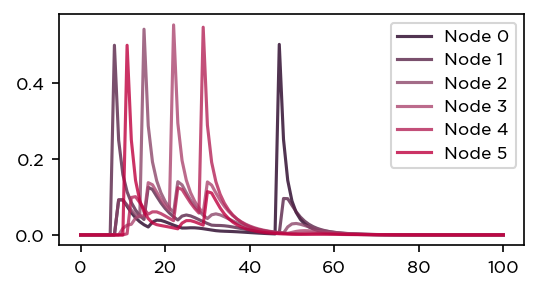

In [10]:
plt.figure(figsize=(4,2),dpi=150)
with sns.color_palette(purple_red,n_colors=example_input.shape[0]):
    plt.plot(symmetric_chain_dynamics.T,alpha=0.8)
plt.legend(['Node 0','Node 1','Node 2','Node 3','Node 4','Node 5']);

In [11]:
cchain = communicability_bin(chain)
cchain[np.diag_indices_from(cchain)] = 0

ccchain = communicability_wei(closedchain)
ccchain[np.diag_indices_from(cchain)] = 0

csychain = communicability_wei(symmetricchain)
csychain[np.diag_indices_from(cchain)] = 0


In [12]:
lesion_params = {'adjacency_matrix': chain, 'input': example_input, 'model_kwargs': model_params}
ci_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=ut.lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)

lesion_params['adjacency_matrix'] = closedchain
ci_closed_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=ut.lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)

lesion_params['adjacency_matrix'] = symmetricchain
ci_symmetric_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=ut.lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)



Doing Nodes:   0%|          | 0/6 [00:00<?, ?it/s]

Doing Nodes:  17%|█▋        | 1/6 [00:01<00:05,  1.01s/it]

Doing Nodes:  33%|███▎      | 2/6 [00:01<00:01,  2.05it/s]

Doing Nodes:  50%|█████     | 3/6 [00:01<00:00,  3.16it/s]

Doing Nodes:  67%|██████▋   | 4/6 [00:01<00:00,  4.29it/s]

Doing Nodes:  83%|████████▎ | 5/6 [00:01<00:00,  4.94it/s]

Doing Nodes:   0%|          | 0/6 [00:00<?, ?it/s]

Doing Nodes:  33%|███▎      | 2/6 [00:00<00:01,  2.64it/s]

Doing Nodes:  50%|█████     | 3/6 [00:01<00:00,  3.65it/s]

Doing Nodes:  67%|██████▋   | 4/6 [00:01<00:00,  4.79it/s]

Doing Nodes:  83%|████████▎ | 5/6 [00:01<00:00,  5.81it/s]

Doing Nodes:   0%|          | 0/6 [00:00<?, ?it/s]

Doing Nodes:  17%|█▋        | 1/6 [00:00<00:00,  7.17it/s]

Doing Nodes:  33%|███▎      | 2/6 [00:00<00:00,  8.09it/s]

Doing Nodes:  50%|█████     | 3/6 [00:00<00:00,  8.14it/s]

Doing Nodes:  67%|██████▋   | 4/6 [00:00<00:00,  8.54it/s]

Doing Nodes:  83%|████████▎ | 5/6 [00:00<00:00,  8.24it/s]

Doing Nodes: 100%|██████████| 6/6 [00:00<00:00,  8.10it/s]


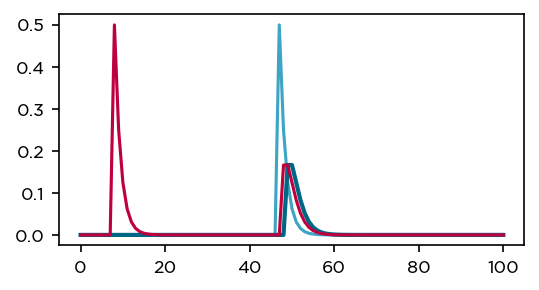

In [13]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(simple_chain_dynamics[0],color=BLUE)
plt.plot(ci_chain[0][1],color=DEEP_BLUE,linewidth=2) #influence of 0 on 1
plt.plot(simple_chain_dynamics[1],color=RED);

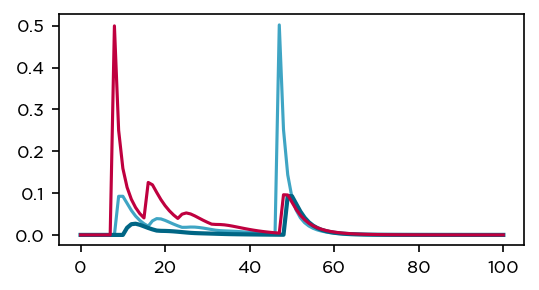

In [14]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(symmetric_chain_dynamics[0],color=BLUE)
plt.plot(ci_symmetric_chain[0][1],color=DEEP_BLUE,linewidth=2) #influence of 0 on 1
plt.plot(symmetric_chain_dynamics[1],color=RED);

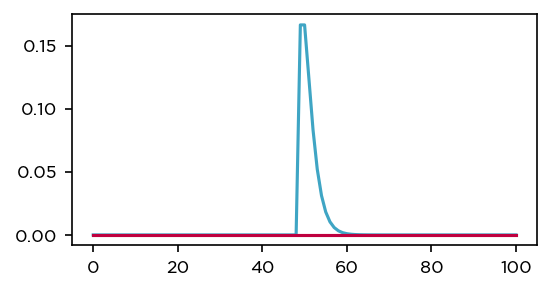

In [15]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(ci_chain[0][1],color=BLUE) #influence of 0 on 1
plt.plot(ci_chain[1][0],color=RED); #influence of 1 on 0

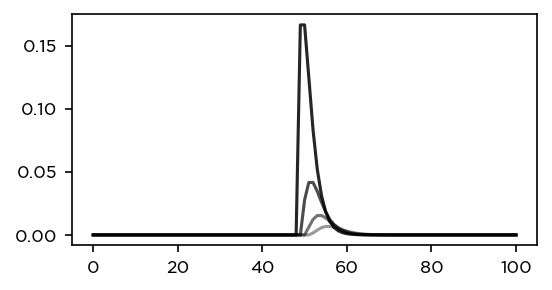

In [16]:
plt.figure(figsize=(4,2),dpi=150)
for i in range(5):
    plt.plot(ci_chain[0][i],color='k',alpha=1-i*0.15) #influence of 0 over the rest


In [17]:
example_modes = ci_symmetric_chain.values.reshape(6,101,6)

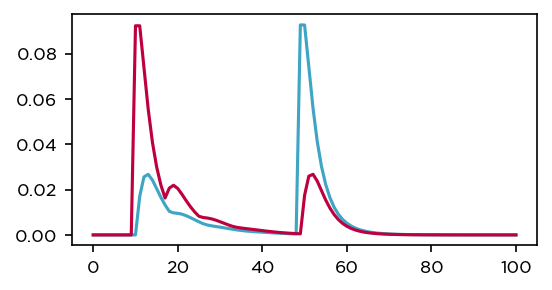

In [18]:
plt.figure(figsize=(4,2),dpi=150)

plt.plot(example_modes[1,:,0],color=BLUE) #influence of 0 on 1
plt.plot(example_modes[0,:,1],color=RED); #influence of 1 on 0

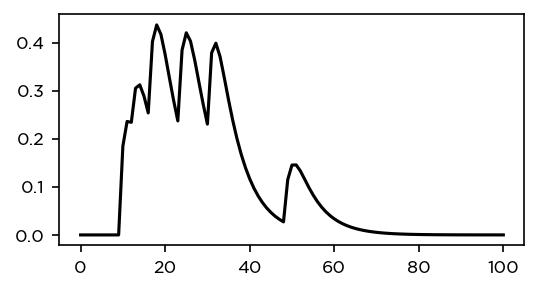

In [19]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(np.nan_to_num(example_modes).sum(axis=0).sum(axis=1),color='k');

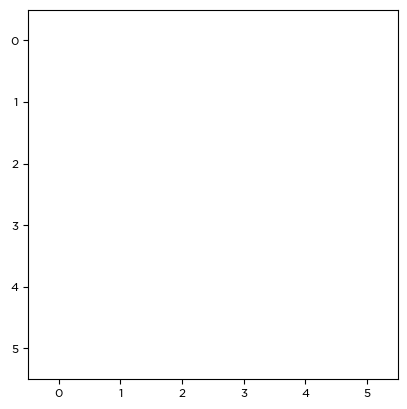

In [20]:
fig, ax = plt.subplots()
heatmaps = [[plt.imshow(example_modes[:,i,:],cmap=white_red_mono,animated=True,vmin=0, vmax=np.nan_to_num(example_modes).max())] for i in range(101)]
anim = animation.ArtistAnimation(fig, heatmaps, interval=60,blit=True)
HTML(anim.to_jshtml())


In [21]:
# f = r"example_causal_contributions.gif" 
# writergif = animation.PillowWriter(fps=30) 
# anim.save(f, writer=writergif)

In [22]:
ci_chain = ci_chain.groupby(level=0).var().fillna(0)
ci_closed_chain = ci_closed_chain.groupby(level=0).var().fillna(0)
ci_symmetric_chain = ci_symmetric_chain.groupby(level=0).var().fillna(0)

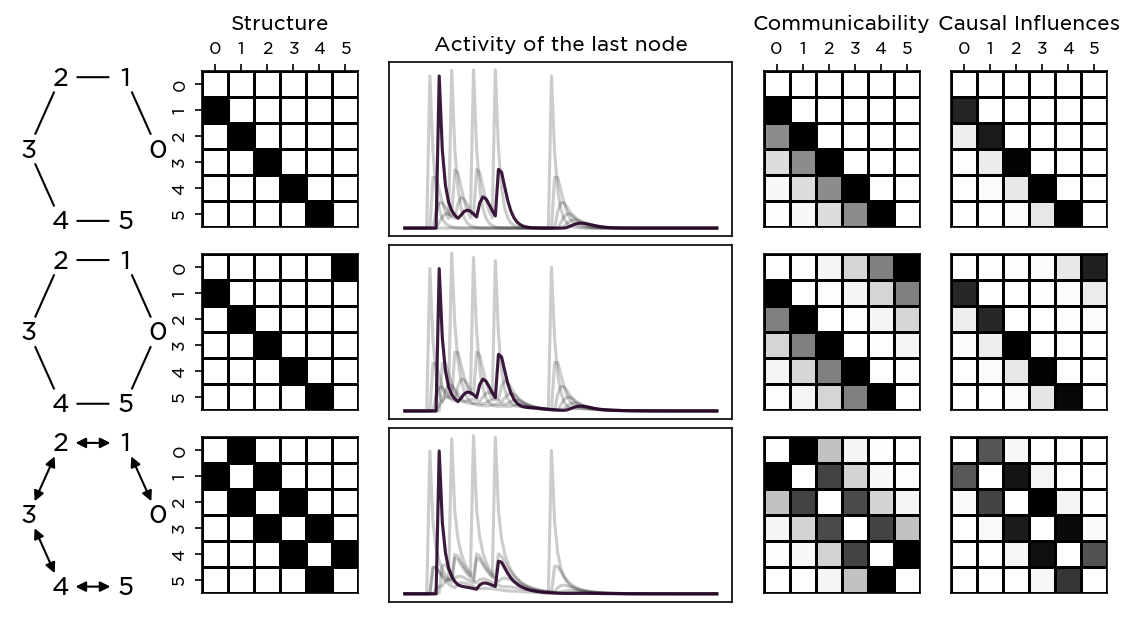

In [23]:
fig,axes = plt.subplot_mosaic([['A','X','B', 'B','CX','CIX'],
                               ['C','Y','D', 'D','CY','CIY'],
                               ['E','Z','F', 'F','CZ','CIZ']],figsize=(7.3,4),dpi=150)

#===================================== STRUCTURE
sns.heatmap(chain,
            square=True,
            cmap='binary',cbar=False,ax=axes['X'],linewidths=0.5, linecolor='k')

sns.heatmap(closedchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['Y'],linewidths=0.5, linecolor='k')

sns.heatmap(symmetricchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['Z'],linewidths=0.5, linecolor='k')
#===================================== COMMUNICABILITY
sns.heatmap(cchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CX'],linewidths=0.5, linecolor='k')

sns.heatmap(ccchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CY'],linewidths=0.5, linecolor='k')

sns.heatmap(csychain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CZ'],linewidths=0.5, linecolor='k')
#===================================== CAUSAL INFLUENCE
sns.heatmap(ci_chain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIX'],linewidths=0.5, linecolor='k')

sns.heatmap(ci_closed_chain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIY'],linewidths=0.5, linecolor='k')

sns.heatmap(ci_symmetric_chain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIZ'],linewidths=0.5, linecolor='k')


node_colors=[WHITE,WHITE,WHITE,WHITE,WHITE,WHITE]
nx.draw_circular(nx.from_numpy_array(chain),ax=axes['A'],
                 arrows=True,node_size=200,node_color=node_colors,with_labels=True)
nx.draw_circular(nx.from_numpy_array(closedchain),ax=axes['C'],
                 arrows=True,node_size=200,node_color=node_colors,with_labels=True)
nx.draw_circular(nx.from_numpy_array(symmetricchain),ax=axes['E'],
                 arrows=True,node_size=200,node_color=node_colors,arrowstyle='<|-|>',with_labels=True)
for ax in ['B','D','F']:

    axes[ax].yaxis.set_visible(False)

for ax in ['B','C','D','Y','Z']:
    axes[ax].xaxis.set_visible(False)
for i in range(len(chain)):
    if i < len(chain)-1:
        axes['B'].plot(simple_chain_dynamics.T[:,i],c='k',alpha=0.2)
    else:
        axes['B'].plot(simple_chain_dynamics.T[:,i],c=PURPLEST,alpha=(0.9))

for i in range(len(chain)):
    if i < len(chain)-1:
        axes['D'].plot(closed_chain_dynamics.T[:,i],c='k',alpha=0.2)
    else:
        axes['D'].plot(closed_chain_dynamics.T[:,i],c=PURPLEST,alpha=(0.9))

for i in range(len(chain)):
        if i < len(chain)-1:
            axes['F'].plot(symmetric_chain_dynamics.T[:,i],c='k',alpha=0.2)
        else:
            axes['F'].plot(symmetric_chain_dynamics.T[:,i],c=PURPLEST,alpha=(0.9))

axes['B'].title.set_text('Activity of the last node')
axes['X'].title.set_text('Structure')
axes['CX'].title.set_text('Communicability')
axes['CIX'].title.set_text('Causal Influences')

axes['B'].yaxis.tick_right()

for ax in ['X','CX','CIX']:
    axes[ax].xaxis.tick_top()
for ax in ['CY','CZ','CIY','CIZ','F']:
    axes[ax].xaxis.set_visible(False)

for ax in ['CX','CY','CZ','CIX','CIY','CIZ']:
    axes[ax].yaxis.set_visible(False)

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)
fig.tight_layout(pad=0.1)

#plt.savefig(f"chain_propagation.pdf",dpi=600,bbox_inches='tight')

In [24]:
res_parcellation = 2 # zero is low res, two is high res
consensus_mat = scipy.io.loadmat('Consensus_Connectomes.mat',simplify_cells=True,squeeze_me=True,chars_as_strings=True)
connectivity = ut.spectral_normalization(1,consensus_mat['LauConsensus']['Matrices'][res_parcellation][0])
fc = consensus_mat['LauConsensus']['Matrices'][res_parcellation][2]
fiber_lengths = consensus_mat['LauConsensus']['Matrices'][res_parcellation][1]
coordinates = consensus_mat['LauConsensus']['Matrices'][res_parcellation][3]
labels = consensus_mat['LauConsensus']['Matrices'][res_parcellation][4][:,0]
fc_modules = consensus_mat['LauConsensus']['Matrices'][res_parcellation][4][:,2]


PearsonRResult(statistic=0.23272827255420686, pvalue=0.0)


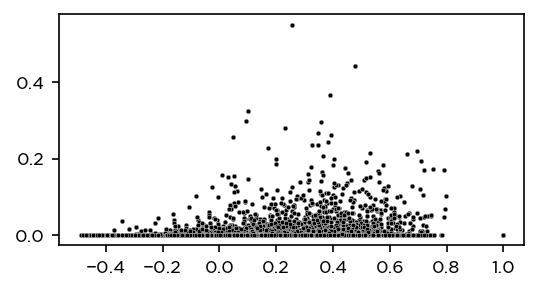

In [25]:
plt.figure(figsize=(4,2),dpi=150)
sns.scatterplot(x=fc.flatten(),y=connectivity.flatten(),color='k',s=5);
print(pearsonr(fc.flatten(),connectivity.flatten()))

In [26]:
ut.check_symmetric(connectivity)

True

In [27]:
N_NODES = len(connectivity)
communication_mask = np.where(communicability_wei(connectivity)!=0,1,0)

In [28]:
rng = np.random.default_rng(seed=SEED)
input_noise = rng.normal(0, 0.5, (N_NODES, int(DURATION/DELTA)+1))
model_params["function"]=ut.tanh
simple_human_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=connectivity,
                                                              input_matrix=input_noise,
                                                              **model_params)


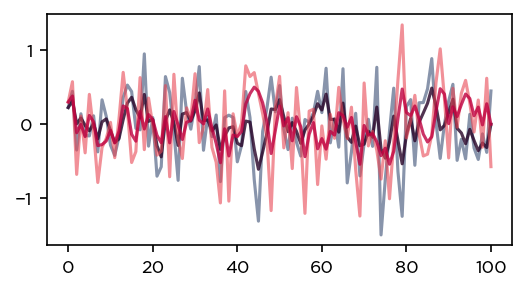

In [29]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(input_noise[-1],alpha=0.6,color=NIGHT_BLUE)
plt.plot(simple_human_dynamics[-1],alpha=0.8,color=PURPLEST)
plt.plot(input_noise[0],alpha=0.6,color=ORANGE)
plt.plot(simple_human_dynamics[0],alpha=0.8,color=RED);
#plt.savefig(f"example_activity.pdf",dpi=600,bbox_inches='tight')

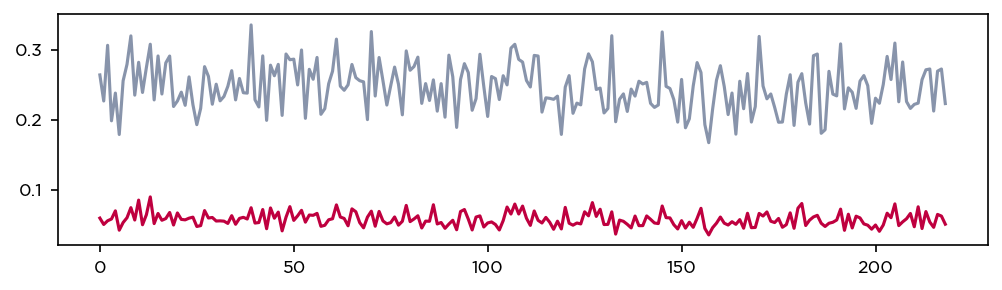

In [30]:
plt.figure(figsize=(8,2),dpi=150)
plt.plot(simple_human_dynamics.var(axis=1),color = RED)
plt.plot(input_noise.var(axis=1),alpha=0.6,color=NIGHT_BLUE);
#plt.xticks(np.arange(0,len(connectivity),1),rotation=90,fontsize=3);

In [31]:
input_output_similarity = []
for node in range(len(simple_human_dynamics)):
    input_output_similarity.append(pearsonr(simple_human_dynamics[node],input_noise[node])[0])

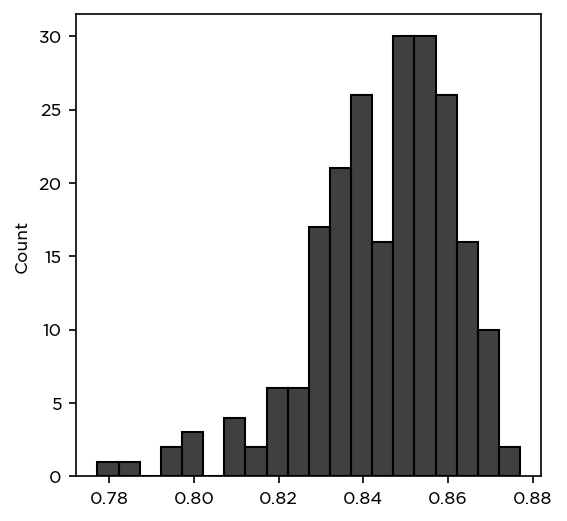

In [32]:
plt.figure(figsize=(4,4),dpi=150)
sns.histplot(input_output_similarity,bins=20,color='k');

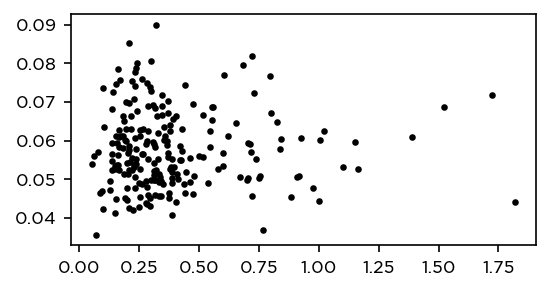

In [33]:
plt.figure(figsize=(4,2),dpi=150)
sns.scatterplot(x=connectivity.sum(axis=0),y=simple_human_dynamics.var(axis=1),color='k',s=10,linewidth=0);

In [34]:
N_TRIALS = 10
all_trials = np.zeros((len(connectivity),len(connectivity),N_TRIALS))

In [35]:
nonlinear = True
if nonlinear:
    for trial in range(N_TRIALS):
        temp = pd.read_pickle(f'results/nonlinear_weighted/causal_modes_nl_w_{len(connectivity)}_{trial}.pickle').groupby(level=0).var().fillna(0)
        all_trials[:,:,trial] = temp
    
    averaged_ci = all_trials.mean(axis=2)
    averaged_ci = pd.DataFrame(averaged_ci)
    
else:
    for trial in range(N_TRIALS):
        temp = pd.read_pickle(f'results/linear_weighted/causal_modes_l_w_{len(connectivity)}_{trial}.pickle').groupby(level=0).var().fillna(0)
        all_trials[:,:,trial] = temp
    
    averaged_ci = all_trials.mean(axis=2)
    averaged_ci = pd.DataFrame(averaged_ci)

if res_parcellation == 0:
    averaged_ci = pd.read_pickle(f'results/causal_modes_hopf_68_0.pickle').groupby(level=0).var().fillna(0)


In [36]:
#averaged_ci = pd.read_pickle(f'results/causal_modes_hopf_219_no_delay_longer_T.pickle').groupby(level=0).sum().fillna(0)
averaged_ci = pd.read_pickle(f'results/causal_modes_hopf_219_no_delay_longer_T.pickle')


In [37]:
hopf_modes = averaged_ci.values.reshape(219,2000,219)
sliced_modes = hopf_modes[:,1000:,:]

In [58]:
averaged_ci = pd.DataFrame(np.nan_to_num(sliced_modes).var(axis=1))

In [59]:
ut.check_symmetric(averaged_ci)

False

In [60]:
diffusion_efficiency = pd.read_csv('results/communication_models/com_mat_DE.txt',header=None)
navigation_efficiency = pd.read_csv('results/communication_models/com_mat_NE.txt',header=None)
search_information = pd.read_csv('results/communication_models/com_mat_SI.txt',header=None)
shortest_path_efficiency = pd.read_csv('results/communication_models/com_mat_SPE.txt',header=None)

In [61]:
lognorm_ci = ut.minmax_normalize(ut.log_normalize(averaged_ci))
np.fill_diagonal(lognorm_ci,0.)

lognorm_comm = ut.minmax_normalize(ut.log_normalize(communicability_wei(connectivity)))
np.fill_diagonal(lognorm_comm,0.)

lognorm_sc = ut.minmax_normalize(ut.log_normalize(connectivity))
np.fill_diagonal(lognorm_sc,0.)
lognorm_sc = np.where(lognorm_sc!=1,lognorm_sc,0)
difference = lognorm_ci-lognorm_comm

scaler = StandardScaler()
difference = scaler.fit_transform(difference)
np.fill_diagonal(difference,0.)

difference_outgoing = ut.make_influence_ratio(difference,axis=0)
difference_incoming = ut.make_influence_ratio(difference,axis=1)

difference_direct = pd.DataFrame(difference).where(connectivity!=0)
difference_indirect = pd.DataFrame(difference).where(connectivity==0)

direct_influence = pd.DataFrame(lognorm_ci).where(connectivity!=0)
indirect_influence = pd.DataFrame(lognorm_ci).where(connectivity==0)

PearsonRResult(statistic=0.7306881459572813, pvalue=0.0)


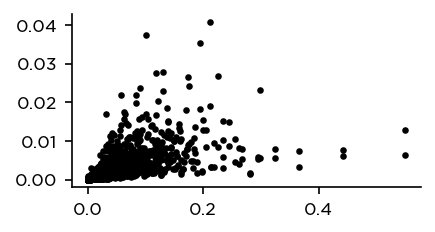

In [145]:
plt.figure(figsize=(3,1.5),dpi=150)
sns.scatterplot(x=connectivity.flatten(),y=averaged_ci.values.flatten(),color='k',s=10,linewidth=0);
sns.despine()

print(pearsonr(connectivity.flatten(),averaged_ci.values.flatten()))

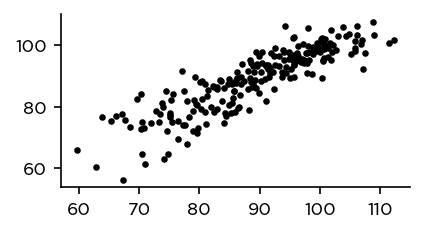

In [144]:
plt.figure(figsize=(3,1.5),dpi=150)
sns.scatterplot(x=lognorm_ci.sum(axis=0),y=lognorm_ci.sum(axis=1),s=10,color='k',linewidth=0)
sns.despine()


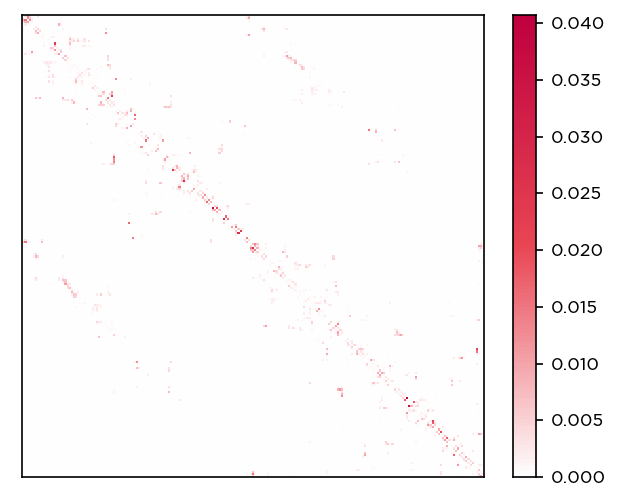

In [64]:
plt.figure(figsize=(5,4),dpi=150)

sns.heatmap(averaged_ci,square=True,xticklabels=False,yticklabels=False, 
            cmap=diverge_from_white,linewidths=0, center=0, linecolor='k')
sns.despine(top=False, right=False, left=False, bottom=False);

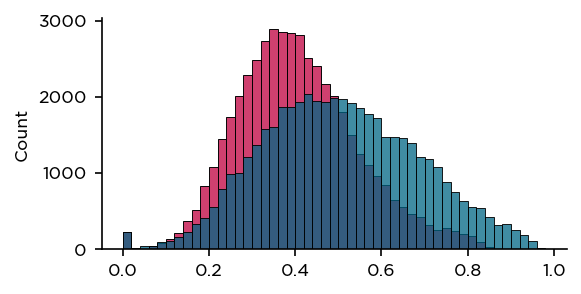

In [143]:
plt.figure(figsize=(4,2),dpi=150)
sns.histplot(lognorm_ci.flatten(),binwidth=0.02,color=RED)
sns.histplot(lognorm_comm.flatten(),binwidth=0.02,color=DEEP_BLUE);
sns.despine()


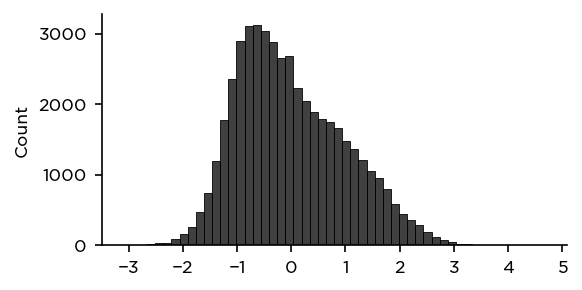

In [142]:
plt.figure(figsize=(4,2),dpi=150)
sns.histplot(difference.flatten(),binwidth=0.15,color='k')
sns.despine()


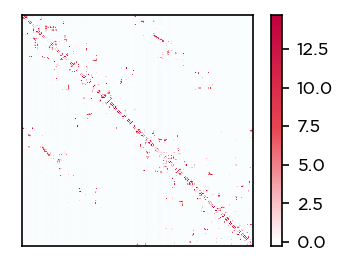

In [67]:
plt.figure(figsize=(3,2),dpi=150)

sns.heatmap(scipy.stats.zscore(averaged_ci),square=True,xticklabels=False,yticklabels=False, 
            cmap=diverge_from_white,linewidths=0, center=0, linecolor='k')
sns.despine(top=False, right=False, left=False, bottom=False);

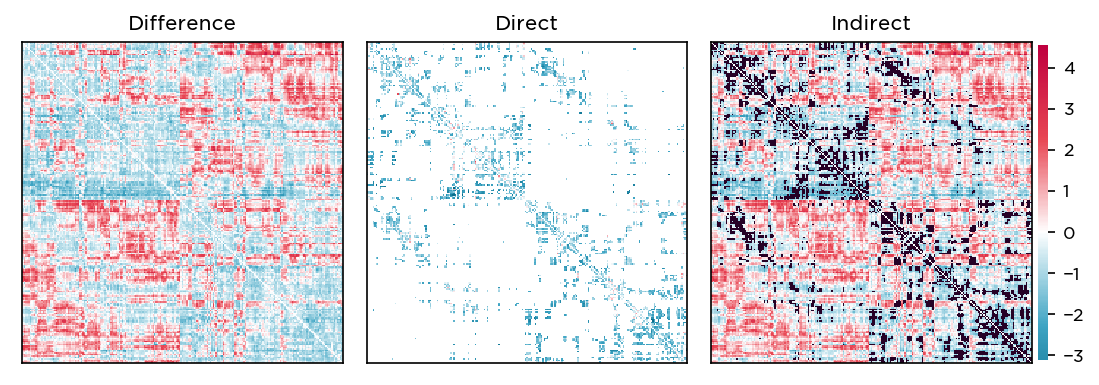

In [68]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=(7,3.5),dpi=150)
cbar_ax = fig.add_axes([.99, .2, .01, .6])

sns.heatmap(difference,square=True,xticklabels=False,yticklabels=False,
            cmap=diverge_from_white,cbar=False,ax=axes['A'],linewidths=0,center=0, linecolor='k')

sns.heatmap(difference_direct,square=True,xticklabels=False,yticklabels=False,center=0, 
            cmap=diverge_from_white,cbar=False,ax=axes['B'],linewidths=0,linecolor='k')

sns.heatmap(difference_indirect,square=True,xticklabels=False,yticklabels=False, 
            cmap=diverge_from_white,cbar_ax=cbar_ax,ax=axes['C'],linewidths=0, center=0, linecolor='k')
for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

axes['A'].title.set_text('Difference')
axes['B'].title.set_text('Direct')
axes['C'].title.set_text('Indirect')
axes['C'].set_facecolor(PURPLEST)
fig.tight_layout(pad=1)

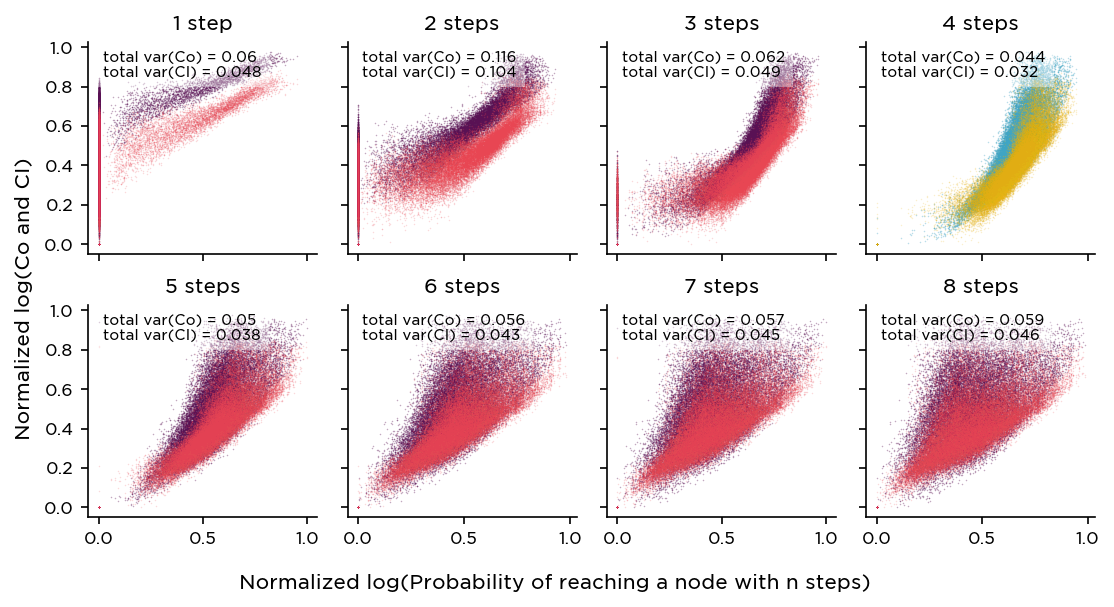

In [141]:
fig,axes = plt.subplots(ncols=4,nrows=2,figsize=(7.5,4),sharey='row',sharex='col',dpi=150)

for path,axis in enumerate(axes.ravel()):
    w = np.linalg.matrix_power(connectivity,path+1)
    w = ut.minmax_normalize(ut.log_normalize(w))
    np.fill_diagonal(w,0.)
    w = np.where(w!=1,w,0)
    total_variance_comm = round(w.var()+lognorm_comm.var(),3)
    total_variance_ci = round(w.var()+lognorm_ci.var(),3)

    if path==3:
        sns.scatterplot(x=w.flatten(),y=lognorm_comm.flatten(),s=0.5,linewidth=0,alpha=0.2,color=BLUE,ax=axis)
        sns.scatterplot(x=w.flatten(),y=lognorm_ci.flatten(),s=0.5,linewidth=0,alpha=0.2,color=YELLOW,ax=axis)
        sns.despine()

    else:
        sns.scatterplot(x=w.flatten(),y=lognorm_comm.flatten(),s=0.5,linewidth=0,alpha=0.2,color=PURPLER,ax=axis)
        sns.scatterplot(x=w.flatten(),y=lognorm_ci.flatten(),s=0.5,linewidth=0,alpha=0.2,color=ORANGE,ax=axis)
        sns.despine()

        
    if path==0:
        axis.set_title(f'{path+1} step')
    else:
        axis.set_title(f'{path+1} steps')
    axis.text(0.02, 0.85, f'total var(Co) = {total_variance_comm}\ntotal var(CI) = {total_variance_ci}', 
              fontsize=7, color='k',bbox=dict(facecolor='white', alpha=0.4, edgecolor='none'))

fig.supxlabel('Normalized log(Probability of reaching a node with n steps)')
fig.supylabel('Normalized log(Co and CI)')

    
fig.tight_layout(pad=1)

In [70]:
graph_distance = -np.log10(connectivity.copy(order='C'))
shortest_path_distance,_ = distance_wei_floyd(np.abs(graph_distance))

In [75]:
np.unravel_index(np.argmax(shortest_path_distance), shortest_path_distance.shape)

(95, 195)

In [77]:
np.unravel_index(np.argmin(shortest_path_distance), shortest_path_distance.shape)

(0, 0)

In [76]:
shortest_path_distance[95,195]

9.863219434714544

In [86]:
pd.DataFrame({'sp':shortest_path_distance[0],'sc':connectivity[0]}).head(50)

sp        sc
0   0.000000  0.000000
1   1.410852  0.038828
2   0.961313  0.109317
3   1.424446  0.037632
4   2.642278  0.000198
5   3.633832  0.000000
6   2.044944  0.009017
7   1.630775  0.023400
8   2.741469  0.001814
9   2.230999  0.000000
10  3.356689  0.000000
11  3.010694  0.000000
12  4.463959  0.000000
13  5.008866  0.000000
14  4.818581  0.000000
15  4.933860  0.000000
16  4.047432  0.000000
17  3.778946  0.000000
18  2.809095  0.000341
19  3.508401  0.000000
20  4.286827  0.000000
21  3.890337  0.000000
22  3.885725  0.000000
23  4.275283  0.000000
24  4.825843  0.000000
25  5.388162  0.000000
26  4.633000  0.000000
27  5.933091  0.000000
28  5.075666  0.000000
29  4.229494  0.000000
30  4.202736  0.000000
31  4.893927  0.000000
32  5.991995  0.000000
33  6.173399  0.000000
34  5.923266  0.000000
35  5.827488  0.000000
36  5.867842  0.000000
37  5.897840  0.000000
38  6.025826  0.000000
39  3.073797  0.000000
40  3.934000  0.000000
41  5.027740  0.000000
42  5.500083  0.000000
43  5.454317  0.000000
44  3.827122  0.000000
45  5.568673  0.000000
46  5.853862  0.000000
47  4.421724  0.000000
48  4.106945  0.000000
49  5.817934  0.000000

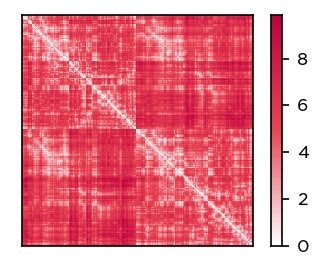

In [508]:
plt.figure(figsize=(3,2),dpi=150)

sns.heatmap(shortest_path_distance,square=True,xticklabels=False,yticklabels=False, 
            cmap=white_red_mono,cbar=True,linewidths=0,linecolor='k')
sns.despine(top=False, right=False, left=False, bottom=False);

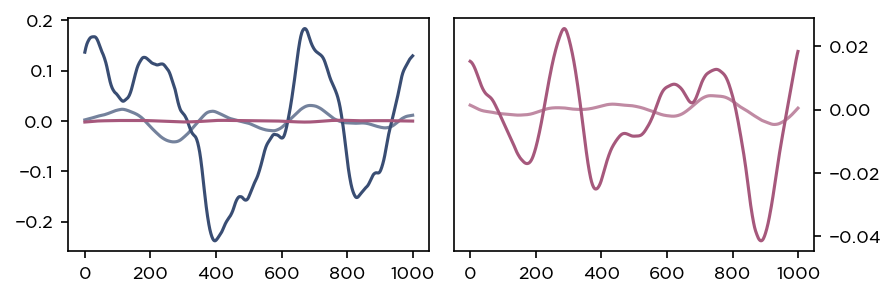

In [140]:
fig,axes = plt.subplot_mosaic([['A','B']],figsize=(6,2),dpi=150)
#influence of [this, :, over this]

axes['A'].plot(sliced_modes[0,:,2],color=NIGHT_BLUE)
axes['A'].plot(sliced_modes[0,:,6],color=NIGHT_BLUE,alpha=0.7)
axes['A'].plot(sliced_modes[0,:,20],color=PURPLE)


axes['B'].plot(sliced_modes[0,:,9],color=PURPLE)
axes['B'].plot(sliced_modes[0,:,44],color=PURPLE,alpha=0.7)
axes['B'].tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)

fig.tight_layout(pad=1)


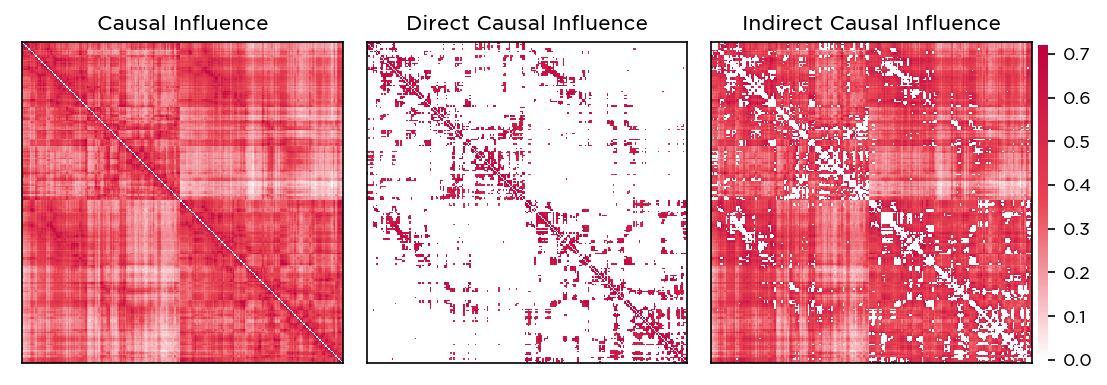

In [93]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=(7,3.5),dpi=150)
cbar_ax = fig.add_axes([.99, .2, .01, .6])

sns.heatmap(lognorm_ci,square=True,xticklabels=False,yticklabels=False,
            cmap=white_red_mono,cbar=False,ax=axes['A'],linewidths=0, linecolor='k')

sns.heatmap(direct_influence,square=True,xticklabels=False,yticklabels=False,center=0, 
            cmap=white_red_mono,cbar=False,ax=axes['B'],linewidths=0,linecolor='k')

sns.heatmap(indirect_influence,square=True,xticklabels=False,yticklabels=False, 
            cmap=white_red_mono,cbar_ax=cbar_ax,ax=axes['C'],linewidths=0, linecolor='k')
for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

axes['A'].title.set_text('Causal Influence')
axes['B'].title.set_text('Direct Causal Influence')
axes['C'].title.set_text('Indirect Causal Influence')
axes['C'].set_facecolor(WHITE)
fig.tight_layout(pad=1)
#plt.savefig(f"causal_influences.pdf",dpi=600,bbox_inches='tight')

In [94]:
indirect_influence.fillna(0,inplace=True)
direct_influence.fillna(0,inplace=True)

indirect_sender_receiver_ratio = pd.DataFrame(data=np.array(indirect_influence.sum(axis=0)/indirect_influence.sum(axis=1)),index=labels)
direct_sender_receiver_ratio = pd.DataFrame(data=np.array(direct_influence.sum(axis=0)/direct_influence.sum(axis=1)),index=labels)

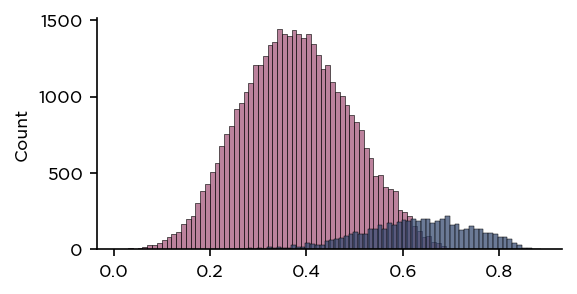

In [133]:
plt.figure(figsize=(4,2),dpi=150)
sns.histplot(indirect_influence.values.flatten()[indirect_influence.values.flatten()!=0],binwidth=0.01,color=PURPLE)
sns.histplot(direct_influence.values.flatten()[direct_influence.values.flatten()!=0],binwidth=0.01,color=NIGHT_BLUE)
sns.despine()


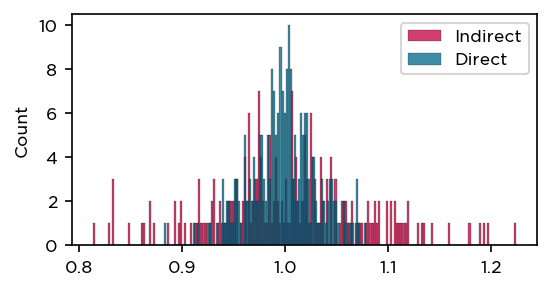

In [96]:
plt.figure(figsize=(4,2),dpi=150)
sns.histplot(indirect_sender_receiver_ratio.values.flatten(),binwidth=0.002,color=RED,label = 'Indirect')
sns.histplot(direct_sender_receiver_ratio.values.flatten(),binwidth=0.002,color=DEEP_BLUE,label = 'Direct')
plt.legend();

In [97]:
indirect_sender_receiver_ratio.sort_values(0,ascending=False).head(10)

0
middletemporal        1.223057
transversetemporal    1.196810
middletemporal        1.191980
superiortemporal      1.189427
rostralmiddlefrontal  1.179499
superiortemporal      1.159838
middletemporal        1.142447
lingual               1.135096
inferiorparietal      1.133289
supramarginal         1.128553

In [98]:
indirect_sender_receiver_ratio.sort_values(0,ascending=True).head(10)

0
fusiform              0.813935
transversetemporal    0.829048
postcentral           0.832171
superiortemporal      0.832368
postcentral           0.833060
lateraloccipital      0.848688
lateralorbitofrontal  0.861773
postcentral           0.862688
superiorfrontal       0.868479
rostralmiddlefrontal  0.869852

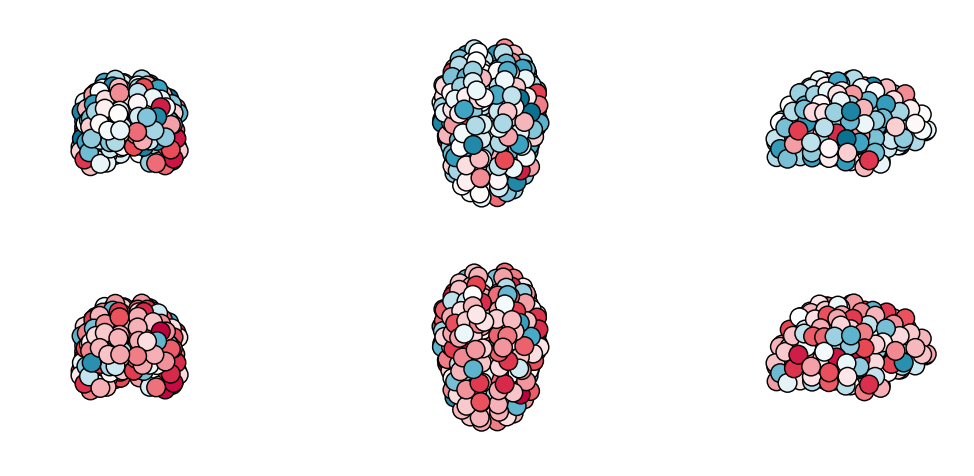

In [99]:
fig,axes = plt.subplot_mosaic([['A','B','C'],['D','E','F']],figsize=(8,3),subplot_kw=dict(projection='3d'),dpi=150)

ut.brain_plotter(indirect_sender_receiver_ratio,coordinates,axes['A'],view=sagittal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(indirect_sender_receiver_ratio,coordinates,axes['B'],view=axial,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(indirect_sender_receiver_ratio,coordinates,axes['C'],view=coronal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)

ut.brain_plotter(direct_sender_receiver_ratio,coordinates,axes['D'],view=sagittal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(direct_sender_receiver_ratio,coordinates,axes['E'],view=axial,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(direct_sender_receiver_ratio,coordinates,axes['F'],view=coronal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
fig.tight_layout(pad=0.1)

<AxesSubplot:xlabel='0', ylabel='0'>

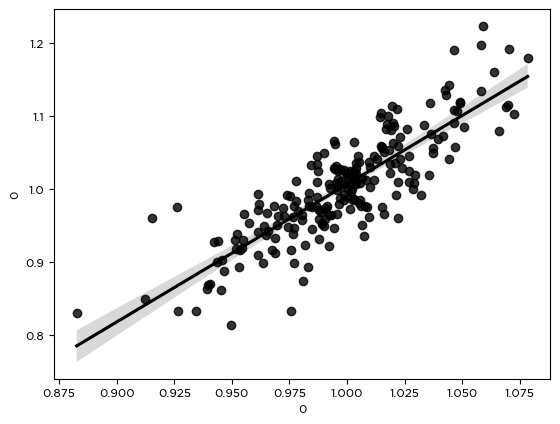

In [100]:
sns.regplot(x=direct_sender_receiver_ratio,y=indirect_sender_receiver_ratio,fit_reg=True,color='k')

In [103]:
influence_gradient = pd.DataFrame(ut.minmax_normalize(ut.threshold(0.5,indirect_influence).sum(0).values),index=labels)

In [104]:
region_desctiptions = scipy.io.loadmat('Simple-Brain-Plot-main/examples/regionDescriptions.mat',simplify_cells=True,squeeze_me=True,chars_as_strings=True)
correct_labels = region_desctiptions['regionDescriptions']['lausanne250']
hemispheres = consensus_mat['LauConsensus']['Matrices'][res_parcellation][4][:,3]


In [105]:
sorted_influence_gradient = ut.preprocess_for_surface_plot(influence_gradient,hemispheres,correct_labels)
scipy.io.savemat('hopf_influence_gradient.mat', {'influence_gradient': sorted_influence_gradient.values})

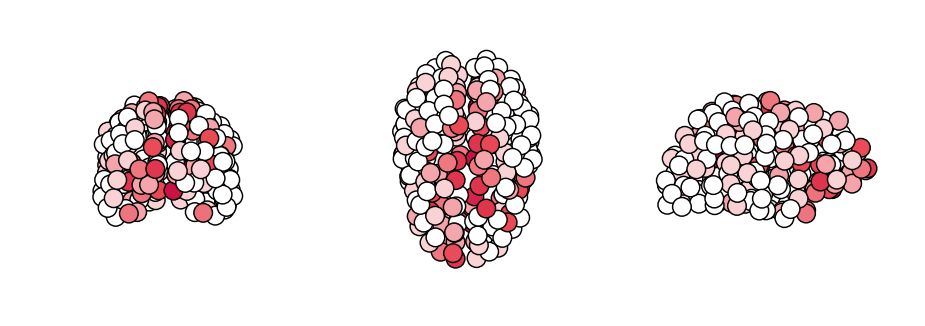

In [106]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=(6,2),subplot_kw=dict(projection='3d'),dpi=150)

ut.brain_plotter(influence_gradient,coordinates,axes['A'],view=sagittal,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(influence_gradient,coordinates,axes['B'],view=axial,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(influence_gradient,coordinates,axes['C'],view=coronal,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)

fig.tight_layout(pad=0.1)
#plt.savefig(f"causal_gradient.pdf",dpi=600,bbox_inches='tight')

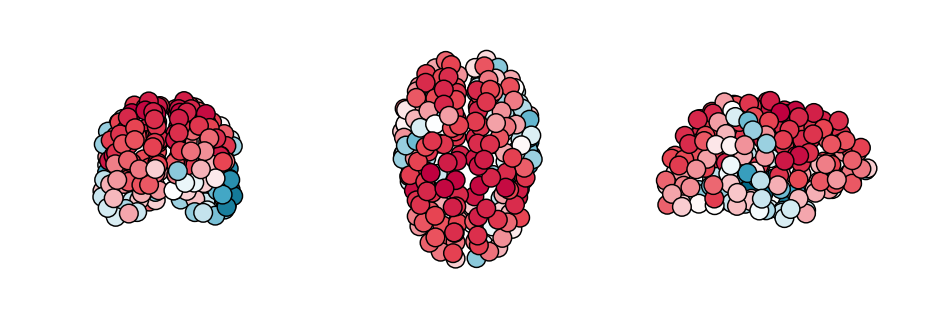

In [107]:
influence_zscore = scipy.stats.zscore(lognorm_ci.sum(axis=1))

fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=(6,2),subplot_kw=dict(projection='3d'),dpi=150)

ut.brain_plotter(influence_zscore,coordinates,axes['A'],view=sagittal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(influence_zscore,coordinates,axes['B'],view=axial,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(influence_zscore,coordinates,axes['C'],view=coronal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)

fig.tight_layout(pad=0.1)

In [108]:
influence_zscore_gradient = pd.DataFrame(influence_zscore,index=labels)
sorted_zscores = ut.preprocess_for_surface_plot(influence_zscore_gradient,hemispheres,correct_labels)
scipy.io.savemat('hopf_zscore_gradient.mat', {'zscore': sorted_zscores.values})

In [109]:
influence_gradient.sort_values(0,ascending=False).head(10)

0
isthmuscingulate         1.000000
precuneus                0.991283
medialorbitofrontal      0.864877
posteriorcingulate       0.862088
caudalanteriorcingulate  0.738347
superiorfrontal          0.623422
lateralorbitofrontal     0.623384
paracentral              0.619550
superiorfrontal          0.616469
superiorfrontal          0.614794

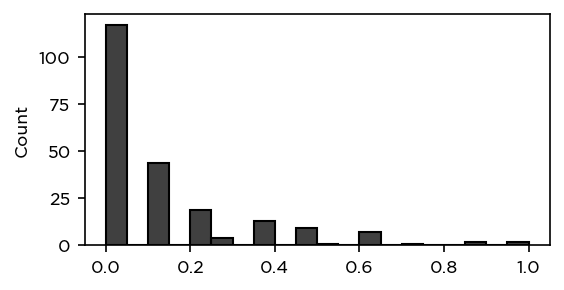

In [110]:
plt.figure(figsize=(4,2),dpi=150)
sns.histplot(influence_gradient.values.flatten(),binwidth=0.05,color='k');

In [66]:
# warnings.filterwarnings("ignore")


# lesion_params = {'adjacency_matrix': connectivity, 'input': input_noise, 'model_kwargs': model_params}

# ci_mat = msa.estimate_causal_influences(elements=list(range(N_NODES)),
#                                         objective_function=ut.lesion_simple_nodes,
#                                         objective_function_params=lesion_params,
#                                         n_permutations=1_000, 
#                                         n_cores=-1,
#                                         parallelize_over_games=True,
#                                         permutation_seed=SEED)

# causal_influences = ci_mat.groupby(level=0).var().fillna(0)


In [67]:
# plt.figure(dpi=150)
# for i in range(n_neurons):
#     plt.plot(ci_mat[i][2],'k',alpha=0.3) # influence on the node
#     plt.plot(ci_mat[2][i],'r',alpha=0.3) # influenced by the node

<AxesSubplot:>

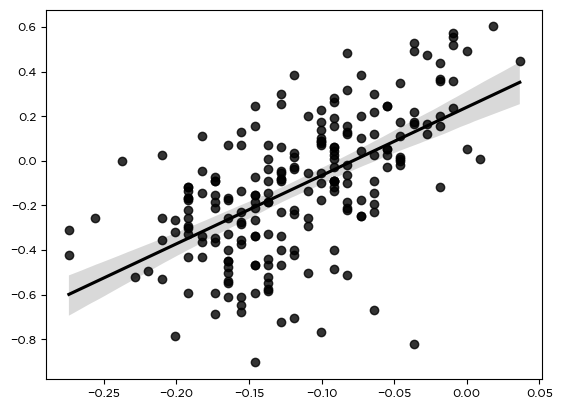

In [111]:
sns.regplot(x=difference_outgoing,y=difference_incoming,fit_reg=True,color='k')

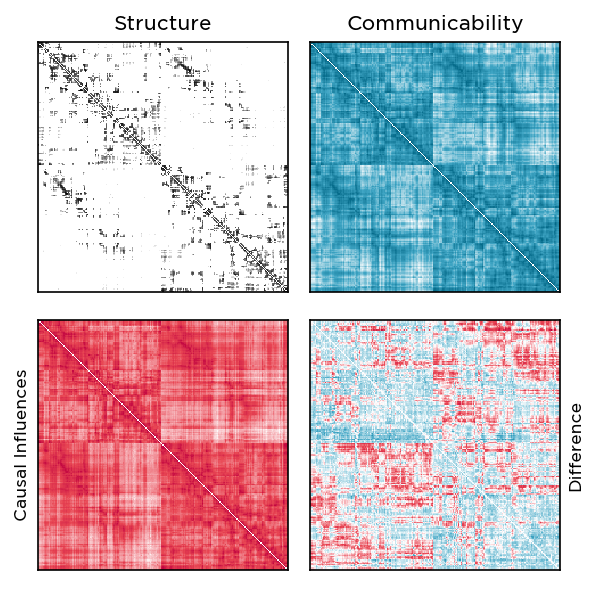

In [112]:
fig,axes = plt.subplot_mosaic([['A','CA'],
                               ['CI','DI']],figsize=(4,4),dpi=150)

sns.heatmap(lognorm_sc,square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['A'],linewidths=0, linecolor='k')
sns.heatmap(lognorm_comm,square=True,xticklabels=False,yticklabels=False,
            cmap=white_blue_mono,cbar=False,ax=axes['CA'],linewidths=0, linecolor='k')

sns.heatmap(lognorm_ci,square=True,xticklabels=False,yticklabels=False,
            cmap=white_red_mono,cbar=False,ax=axes['CI'],linewidths=0, linecolor='k')
sns.heatmap(difference,square=True,xticklabels=False,yticklabels=False,center=0,
            cmap=diverge_from_white,cbar=False,ax=axes['DI'],linewidths=0, linecolor='k')

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

axes['A'].title.set_text('Structure')
axes['CA'].title.set_text('Communicability')
axes['CI'].set_ylabel("Causal Influences")
axes['DI'].set_ylabel("Difference")
axes['DI'].yaxis.set_label_position("right")
fig.tight_layout(pad=1)
#plt.savefig(f"human_propagation.pdf",dpi=600,bbox_inches='tight')

In [113]:
direct_indirect_hue = indirect_influence.where(indirect_influence == 0, -1)+direct_influence.where(direct_influence == 0, 1)

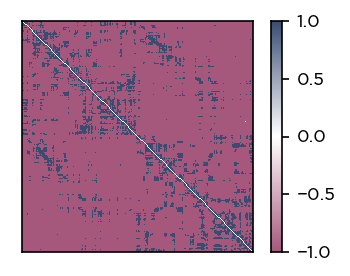

In [114]:
plt.figure(figsize=(3,2),dpi=150)

sns.heatmap(direct_indirect_hue,square=True,xticklabels=False,yticklabels=False, 
            cmap=purples_diverge_from_white,linewidths=0, center=0, linecolor='k')
sns.despine(top=False, right=False, left=False, bottom=False);

communicability: PearsonRResult(statistic=0.9162837755451, pvalue=0.0)
graph distance: PearsonRResult(statistic=-0.8605686290038667, pvalue=0.0)


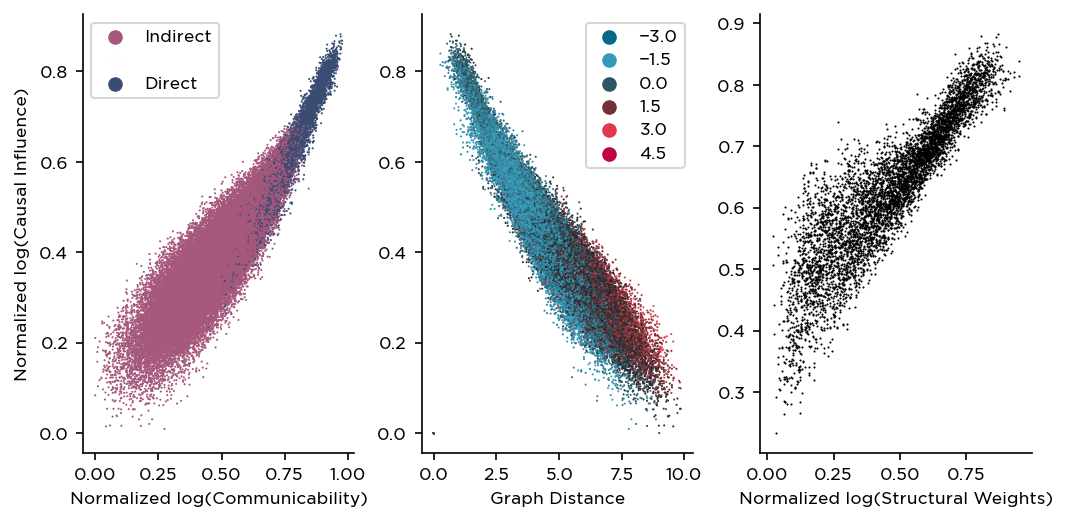

In [150]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=(7,3.5),dpi=150)
sns.scatterplot(x=lognorm_comm.flatten(),y=lognorm_ci.flatten(),hue = direct_indirect_hue.values.flatten(),
                palette=purples_diverge_from_white,ax=axes['A'],s=1,linewidth=0)
sns.despine()

new_labels = ['Indirect','', 'Direct']
for i, text in enumerate(axes['A'].get_legend().get_texts()):
    text.set_text(new_labels[i])

sns.scatterplot(x=shortest_path_distance.flatten(),y=lognorm_ci.flatten(),ax=axes['B'],hue = difference.flatten(),
                palette=diverge_from_black, s=1,linewidth=0)
sns.despine()

sns.scatterplot(x=lognorm_sc.flatten()[lognorm_sc.flatten()!=0],y=direct_influence.values.flatten()[lognorm_sc.flatten()!=0],color='k',ax=axes['C'],s=1,linewidth=0)
sns.despine()

axes['A'].set_xlabel('Normalized log(Communicability)')
axes['A'].set_ylabel('Normalized log(Causal Influence)')
axes['B'].set_xlabel('Graph Distance')

axes['C'].set_xlabel('Normalized log(Structural Weights)')
fig.tight_layout(pad=1);
print(f'communicability: {pearsonr(lognorm_comm.flatten(),lognorm_ci.flatten())}')
print(f'graph distance: {pearsonr(shortest_path_distance.flatten(),lognorm_ci.flatten())}')

#plt.savefig(f"correlations.pdf",dpi=600,bbox_inches='tight')

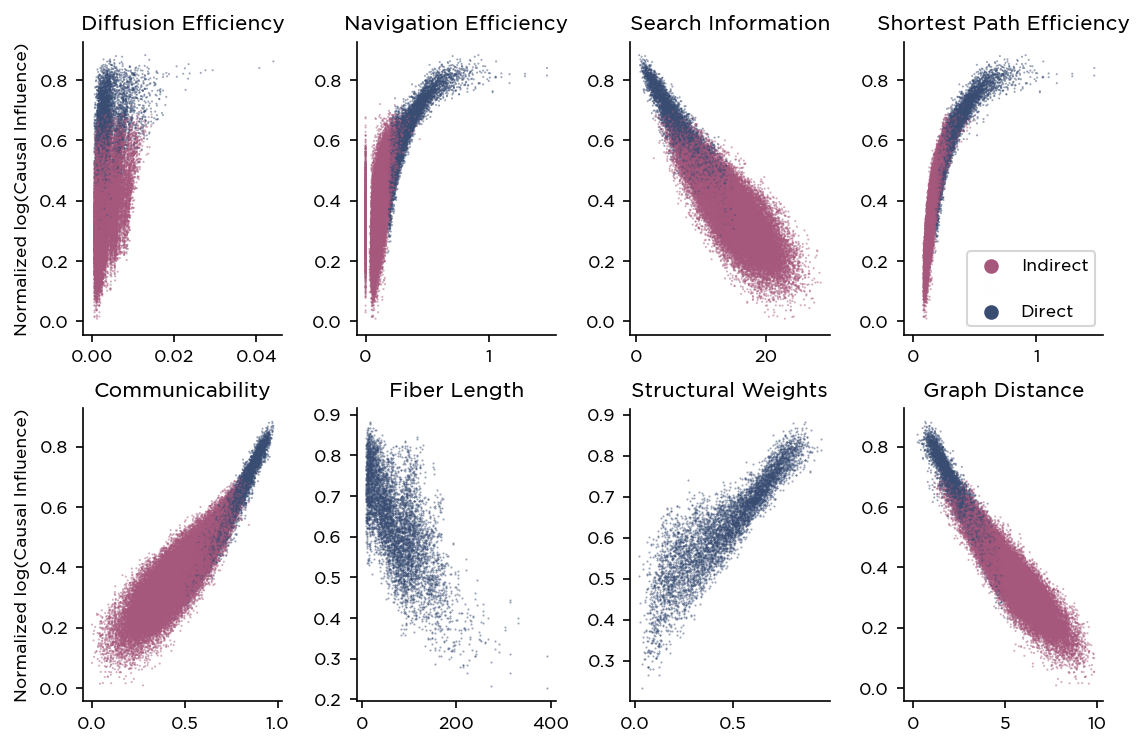

In [131]:
fig,axes = plt.subplot_mosaic([['A','B','C','D'],
                               ['E','F','G','H']],figsize=(7.5,5),dpi=150)

sns.scatterplot(x=diffusion_efficiency.values.flatten(),y=lognorm_ci.flatten(),hue = direct_indirect_hue.values.flatten(),
                palette=purples_diverge_from_white,ax=axes['A'],s=1,linewidth=0,alpha=0.5)
sns.despine()

sns.scatterplot(x=navigation_efficiency.values.flatten(),y=lognorm_ci.flatten(),hue = direct_indirect_hue.values.flatten(),
                palette=purples_diverge_from_white,ax=axes['B'],s=1,linewidth=0,alpha=0.5)
sns.despine()

sns.scatterplot(x=search_information.values.flatten(),y=lognorm_ci.flatten(),hue = direct_indirect_hue.values.flatten(),
                palette=purples_diverge_from_white,ax=axes['C'],s=1,linewidth=0,alpha=0.5)
sns.despine()

sns.scatterplot(x=shortest_path_efficiency.values.flatten(),y=lognorm_ci.flatten(),hue = direct_indirect_hue.values.flatten(),
                palette=purples_diverge_from_white,ax=axes['D'],s=1,linewidth=0,alpha=0.5)
sns.despine()

sns.scatterplot(x=lognorm_comm.flatten(),y=lognorm_ci.flatten(),hue = direct_indirect_hue.values.flatten(),
                palette=purples_diverge_from_white,ax=axes['E'],s=1,linewidth=0,alpha=0.5)
sns.despine()

sns.scatterplot(x=fiber_lengths[fiber_lengths!=0].flatten(),y=lognorm_ci[fiber_lengths!=0].flatten(),color=NIGHT_BLUE,ax=axes['F'],s=1,linewidth=0,alpha=0.5)
sns.despine()

sns.scatterplot(x=lognorm_sc.flatten()[lognorm_sc.flatten()!=0],y=direct_influence.values.flatten()[lognorm_sc.flatten()!=0],color=NIGHT_BLUE,ax=axes['G'],s=1,linewidth=0,alpha=0.5)
sns.despine()

sns.scatterplot(x=shortest_path_distance.flatten(),y=lognorm_ci.flatten(),ax=axes['H'],hue = direct_indirect_hue.values.flatten(),
                palette=purples_diverge_from_white,s=1,linewidth=0,alpha=0.5)
sns.despine()

axes['A'].set_title('Diffusion Efficiency')
axes['B'].set_title('Navigation Efficiency')
axes['C'].set_title('Search Information')
axes['D'].set_title('Shortest Path Efficiency')
axes['E'].set_title('Communicability')
axes['F'].set_title('Fiber Length')
axes['G'].set_title('Structural Weights')
axes['H'].set_title('Graph Distance')


axes['A'].set_ylabel('Normalized log(Causal Influence)')
axes['E'].set_ylabel('Normalized log(Causal Influence)')


for i, text in enumerate(axes['D'].get_legend().get_texts()):
    text.set_text(new_labels[i])
for ax in ['A','B','C','E','H']:
    axes[ax].legend().remove()
fig.tight_layout(pad=1);

In [117]:
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()
linear_regressor.fit(lognorm_sc.flatten()[lognorm_sc.flatten()!=0].reshape(-1, 1), direct_influence.values.flatten()[lognorm_sc.flatten()!=0])
Y_pred = linear_regressor.predict(lognorm_sc.flatten()[lognorm_sc.flatten()!=0].reshape(-1, 1))
residuals = direct_influence.values.flatten()[lognorm_sc.flatten()!=0] - Y_pred

In [118]:
residual_matrix = lognorm_sc.copy()
residual_matrix[residual_matrix!=0] = residuals

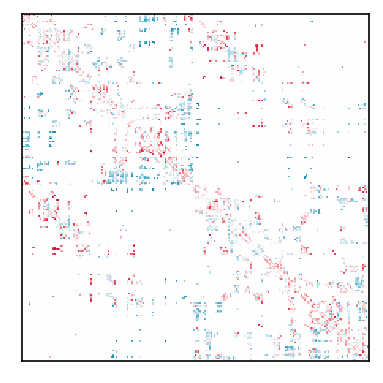

In [119]:
plt.figure(figsize=(3,3),dpi=150)
sns.heatmap(residual_matrix,square=True,xticklabels=False,yticklabels=False,
            cmap=diverge_from_white,cbar=False,linewidths=0, linecolor='k',center=0)
sns.despine(top=False, right=False, left=False, bottom=False)


In [120]:
ut.check_symmetric(residual_matrix)

False

In [121]:
import matplotlib.colors as mcolors

vcenter = 0
vmin, vmax = residuals.min(), residuals.max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)

PearsonRResult(statistic=0.9005453539306375, pvalue=0.0)


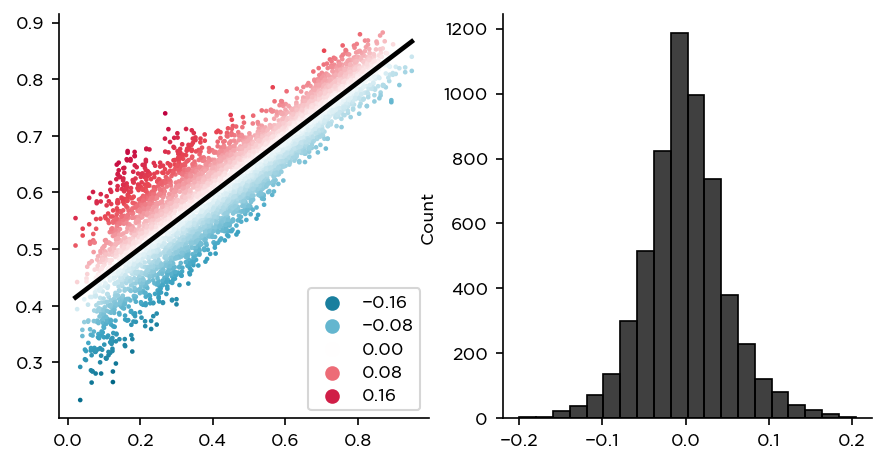

<Figure size 450x450 with 0 Axes>

In [148]:
fig,axes = plt.subplot_mosaic([['A','B']],figsize=(7,3.5),dpi=150)

sns.scatterplot(x=lognorm_sc.flatten()[lognorm_sc.flatten()!=0],y=direct_influence.values.flatten()[lognorm_sc.flatten()!=0],
                hue=residual_matrix.flatten()[lognorm_sc.flatten()!=0],palette=diverge_from_white,s=5, hue_norm=normalize,linewidth=0,ax=axes['A'])
sns.regplot(x=lognorm_sc.flatten()[lognorm_sc.flatten()!=0],y=direct_influence.values.flatten()[lognorm_sc.flatten()!=0],scatter=False,color='k',ax=axes['A']);
sns.despine()

plt.figure(figsize=(3,3),dpi=150)
sns.histplot(residuals,bins=20,color='k',ax=axes['B'])
sns.despine()
print(pearsonr(lognorm_sc.flatten()[lognorm_sc.flatten()!=0],direct_influence.values.flatten()[lognorm_sc.flatten()!=0]))


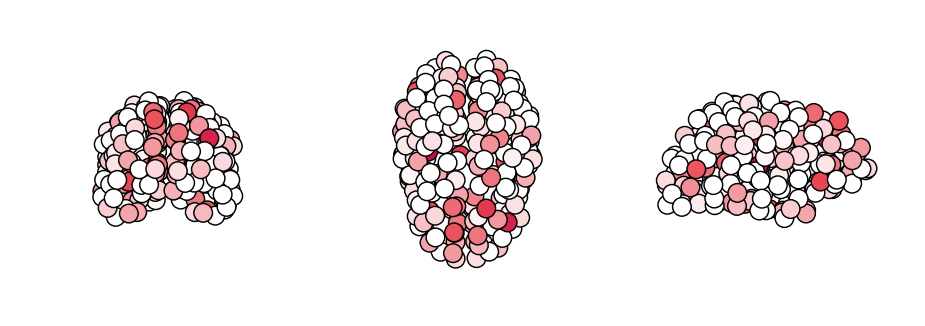

In [127]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=(6,2),subplot_kw=dict(projection='3d'),dpi=150)

ut.brain_plotter(np.clip(residual_matrix.sum(axis=0),a_min=0,a_max=None),coordinates,axes['A'],view=sagittal,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(np.clip(residual_matrix.sum(axis=0),a_min=0,a_max=None),coordinates,axes['B'],view=axial,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(np.clip(residual_matrix.sum(axis=0),a_min=0,a_max=None),coordinates,axes['C'],view=coronal,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)
fig.tight_layout(pad=0.1)

In [128]:
residual_gradient = pd.DataFrame(residual_matrix.sum(axis=0),index=labels)
sorted_residuals = ut.preprocess_for_surface_plot(residual_gradient,hemispheres,correct_labels)
scipy.io.savemat('hopf_residual_gradient.mat', {'residual_gradient': sorted_residuals.values})